### Heart Disease Prediction - Modeling

Import necessary libraries and data

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#warnings.filterwarnings('error', category=DeprecationWarning)

In [325]:
#load training and test data
X_train = pd.read_csv('X_train.csv', index_col = False)
y_train = pd.read_csv('y_train.csv', index_col = False)
X_test = pd.read_csv('X_test.csv',  index_col = False)
y_test = pd.read_csv('y_test.csv', index_col = False)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Context

For the modeling portiion of this capstone we will be considering several different models which are useful for binary classification problems like the one we are dealing with in this instance. For each we will be considering Accuracy, Recall, Feature importance, and the ROC curve as metrics. For this context, recall will be the primary metric that is used to measure the performance of each model. Recall was chosen because if this analysis was being done in a clinical setting, it is more important to avoid the false negative of wrongly clearing a patient with heart disease than it is to avoid a false positive, due to the relative harm of each outcome. 




Variables explained 
    - age: patient age in years
    - sex: patient sex (1 = male, 0 = female)
    - cp: Type of chest pain experienced (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
    - trestbps: patient resting blood pressure (mmHg measured at intake into hospital)
    - chol: patient cholesterol level (mg/dl)
    - fbs: patient fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
    - restecg: patient resting electrocardiograph measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
    - thalach: patient maximum heart rate achieved
    - exang: exercise induced angina (1 = yes; 0 = no)
    - oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
    - slope: the slope of the peak exercise ST segment (1: upsloping, 2: flat, 3: downsloping)
    - ca: number of major vessels  (0-3)
    - thal: see below (3 = normal; 6 = fixed defect; 7 = reversable defect)
    - target: presence of heart disease (0 = not present, 1 = present.)


Background on Thalium Tracer test (thal)
--Nuclear stress testing requires the injection of a tracer, commonly technicium 99M (Myoview or Cardiolyte), which is then taken up by healthy, viable myocardial cells. A camera (detector) is used afterwards to image the heart and compare segments. A coronary stenosis is detected when a myocardial segment takes up the nuclear tracer at rest, but not during cardiac stress. This is called a "reversible defect." Scarred myocardium from prior infarct will not take up tracer at all and is referred to as a "fixed defect."

## Model : Logistic Regression
   - *Application*: Using logistic regresison for this problem because it is a fundamental model for binary classification tasks.
       - *Advantages*: It provides probabilities for outcomes, which can be helpful for making clinical decisions based on risk thresholds. Logistic regression is also very interpretable, as the coefficients of the model can be used to understand the influence of each feature.
       - *Limitations*: It assumes linearity between the dependent variable and the independent variables, which might not always hold true.


In [326]:
#choose liblinear solver due to relatively small dataset and binary classification
classifier_LR = LogisticRegression(C=0.1, solver='newton-cg', max_iter = 500)

In [327]:
# fit training data with classifer, use ravel() to ensure y input is flattened
classifier_LR.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')

In [328]:
y_predict_test_LR = classifier_LR.predict(X_test)
y_predict_training_LR = classifier_LR.predict(X_train)

In [329]:
print("[Training] Accuracy score LR: (y_train, y_predict_training)", 
      f'{accuracy_score(y_train, y_predict_training_LR):.2f}')

print("[Training] Recall score LR: (y_train, y_predict_training)",
      f'{recall_score(y_train, y_predict_training_LR):.2f}')

[Training] Accuracy score LR: (y_train, y_predict_training) 0.87
[Training] Recall score LR: (y_train, y_predict_training) 0.82


In [330]:
print("[Test] Accuracy score LR: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_test_LR, y_test):.2f}')
print("[Test] Recall score LR: (y_predict_test, y_test):",
      f'{recall_score(y_predict_test_LR, y_test):.2f}')

[Test] Accuracy score LR: (y_predict_test, y_test): 0.83
[Test] Recall score LR: (y_predict_test, y_test): 0.81


<Axes: ylabel='Feature'>

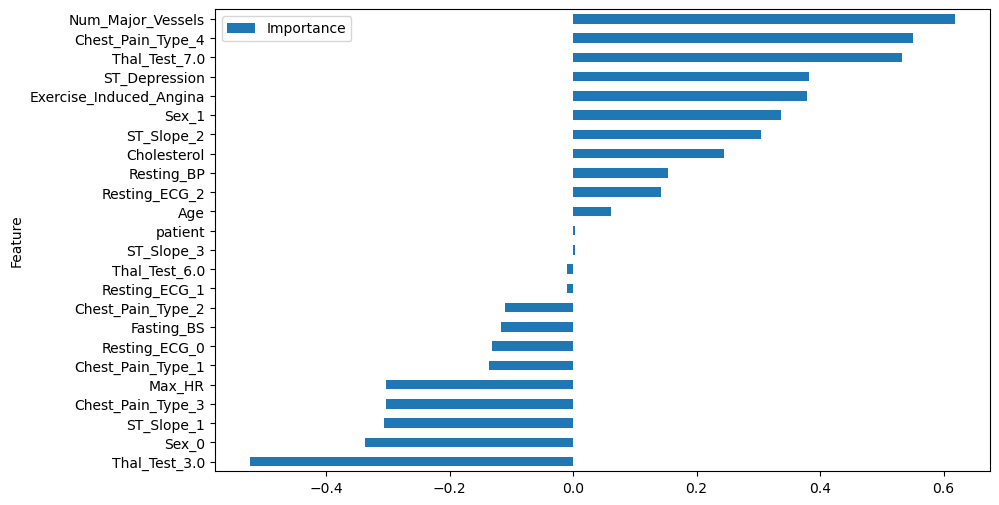

In [334]:
# get feature importance
importance = classifier_LR.coef_.ravel()
# summarize feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

The positive coefficients indicate a feature that more likely indicates heart disease, whereas the negative coefficients indicate a feature that more likely indicates no disease. 

In this instance, it means that the 

Print the confusion matrix





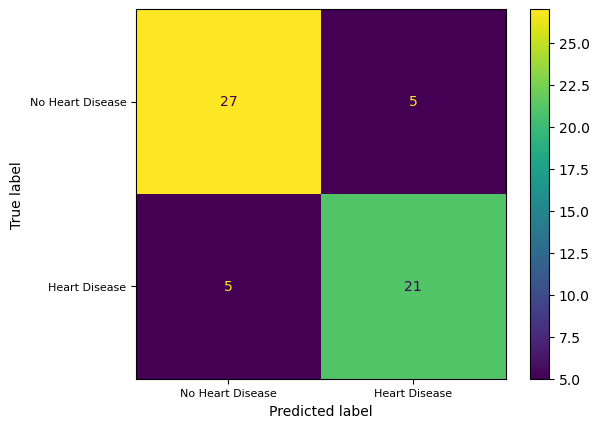

In [40]:
cm = confusion_matrix(y_test, y_predict_test_LR, labels = classifier_LR.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No Heart Disease', 'Heart Disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

In [263]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'liblinear']
}
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
gscv = GridSearchCV(classifier_LR, param_grid = param_grid,  scoring = 'recall', cv = 5).fit(X_train, y_train.values.ravel())
warnings.filterwarnings('ignore')
print('best score:', gscv.score(X_test, y_test))
print('best params:', gscv.best_estimator_)

# get predicted values
y_predict_GSCV_LR = gscv.predict(X_test)

print("[Test] Accuracy score Grid Search CV - LR: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_GSCV_LR, y_test):.2f}')
print("[Test] Recall score Grid Search CV - LR: (y_predict_test, y_test):",
      f'{recall_score(y_predict_GSCV_LR, y_test):.2f}')

best score: 0.8076923076923077
best params: LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')
[Test] Accuracy score Grid Search CV - LR: (y_predict_test, y_test): 0.83
[Test] Recall score Grid Search CV - LR: (y_predict_test, y_test): 0.81


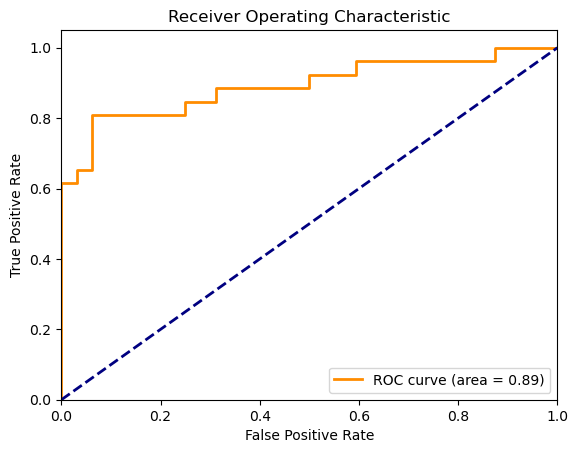

In [111]:
probas = classifier_LR.predict_proba(X_test)[:, 1]  # get the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

## Model : Support Vector Machines

 - *Application*: Trying SVM here because it works well in high-dimensional spaces and our dataset is not overly large.
   - *Advantages*: SVMs are powerful in capturing complex relationships in data by using a kernel trick to operate in a transformed feature space.
   - *Limitations*: They require careful tuning of parameters, such as the choice of kernel and regularization term. They also tend to be less efficient on very large datasets.


In [356]:
classifier_SV = SVC(kernel = 'linear', C = 0.01, random_state = 123, probability = True)

In [357]:
classifier_SV.fit(X_train, y_train.values.ravel())

SVC(C=0.01, kernel='linear', probability=True, random_state=123)

In [358]:
y_predict_test_SV = classifier_SV.predict(X_test)
y_predict_training_SV = classifier_SV.predict(X_train)

In [359]:
print("[Training] Accuracy score SV: (y_train, y_predict_training)", 
      f'{accuracy_score(y_train, y_predict_training_SV):.2f}')
print("[Training] Recall score SV: (y_train, y_predict_training)", 
      f'{recall_score(y_train, y_predict_training_SV):.2f}')

[Training] Accuracy score SV: (y_train, y_predict_training) 0.87
[Training] Recall score SV: (y_train, y_predict_training) 0.79


In [360]:
print("[Test] Accuracy score SV: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_test_SV, y_test):.2f}')
print("[Test] Recall score SV: (y_predict_test, y_test):",
      f'{recall_score(y_predict_test_SV, y_test):.2f}')

[Test] Accuracy score SV: (y_predict_test, y_test): 0.86
[Test] Recall score SV: (y_predict_test, y_test): 0.88


In [269]:
param_grid = {
    'C': [0.01,0.1,1,10],
    'kernel': ['linear', 'rbf']
}
# use grid search cv
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
gscv = GridSearchCV(classifier_SV, param_grid = param_grid, cv= 5).fit(X_train, y_train.values.ravel())

print("Optimal Parameters:", gscv.best_params_)
print("Best Score  :", gscv.best_score_)

# get predicted values
y_predict_GSCV_SV = gscv.predict(X_test)

print("[Test] Accuracy score Grid Search CV - SV: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_GSCV_SV, y_test):.2f}')
print("[Test] Recall score Grid Search CV - SV: (y_predict_test, y_test):",
      f'{recall_score(y_predict_GSCV_SV, y_test):.2f}')

Optimal Parameters: {'C': 0.01, 'kernel': 'linear'}
Best Score  : 0.8580943570767807
[Test] Accuracy score Grid Search CV - SV: (y_predict_test, y_test): 0.86
[Test] Recall score Grid Search CV - SV: (y_predict_test, y_test): 0.88


<Axes: ylabel='Feature'>

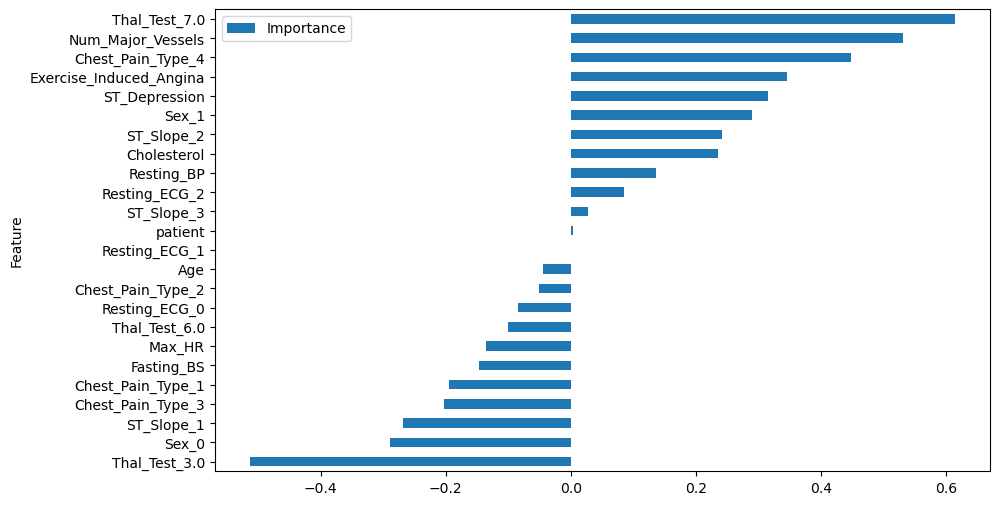

In [336]:
# get feature importance
importance = classifier_SV.coef_.ravel()
# summarize feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

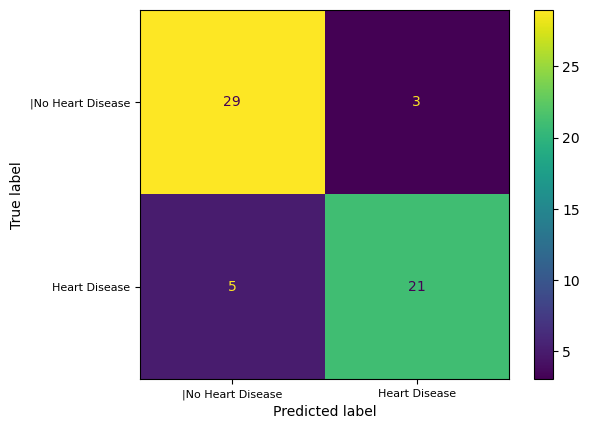

In [118]:
cm = confusion_matrix(y_test, y_predict_test_SV, labels = classifier_LR.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['|No Heart Disease', 'Heart Disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

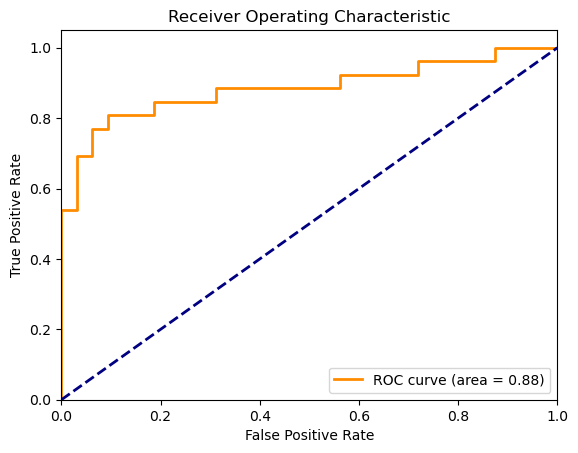

In [119]:
probas = classifier_SV.predict_proba(X_test)[:, 1]  # get the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model: Decision Trees
*Application*:Trying Decision trees here because they are non-parametric models that recursively partition the data into subsets, which makes them excellent for handling complex pattern recognition tasks involving interactions between variables.
   - *Advantages*: They are easy to interpret and can handle both numerical and categorical data without the need for scaling.
   - *Limitations*: They are prone to overfitting, especially with many features. However, this can be mitigated by setting constraints on tree size or using ensemble methods.


In [310]:
classifier_DT = DecisionTreeClassifier(max_depth = 3,)

In [311]:
classifier_DT.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=3)

In [312]:
# predicting values
y_predict_test_DT = classifier_DT.predict(X_test)
y_predict_training_DT = classifier_DT.predict(X_train)

In [313]:
print("[Training] Accuracy score DT: (y_train, y_predict_training)", 
      f'{accuracy_score(y_train, y_predict_training_DT):.2f}')
print("[Training] Recall score DT: (y_train, y_predict_training)", 
      f'{recall_score(y_train, y_predict_training_DT):.2f}')

[Training] Accuracy score DT: (y_train, y_predict_training) 0.87
[Training] Recall score DT: (y_train, y_predict_training) 0.88


In [314]:
print("[Test] Accuracy score DT: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_test_DT, y_test):.2f}')
print("[Test] Recall score DT: (y_train, y_predict_training)", 
      f'{recall_score(y_predict_test_DT, y_test):.2f}')

[Test] Accuracy score DT: (y_predict_test, y_test): 0.79
[Test] Recall score DT: (y_train, y_predict_training) 0.73


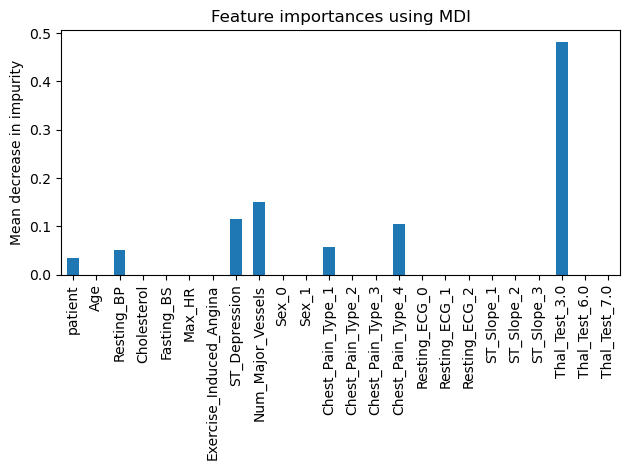

In [349]:
# get feature importance
importance = classifier_DT.feature_importances_
DT_importance = pd.Series(importance, index=X.columns)

fig, ax = plt.subplots()
DT_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


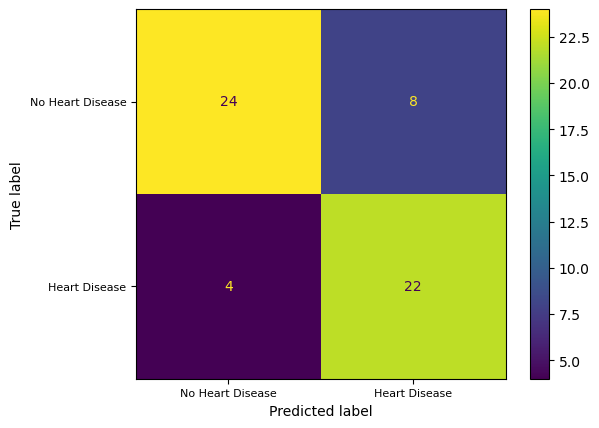

In [315]:
cm = confusion_matrix(y_test, y_predict_test_DT, labels = classifier_LR.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No Heart Disease', 'Heart Disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

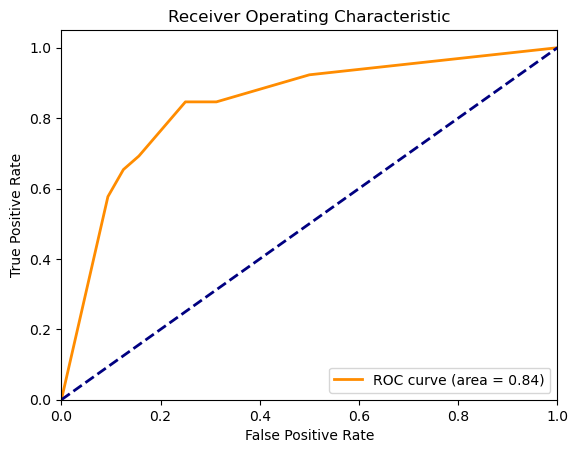

In [316]:
probas = classifier_DT.predict_proba(X_test)[:, 1]  # get the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model: Random Forest
 - *Use Case*: Trying RF here because they are an ensemble of decision trees that improves prediction accuracy and controls overfitting by averaging multiple deep decision trees trained on different parts of the same training set.
   - *Advantages*: Random forests generally provide much higher accuracy than a single decision tree and are good at handling outliers and nonlinear data.
   - *Limitations*: They are less interpretable than single decision trees due to their complexity.


In [317]:
classifier_RF = RandomForestClassifier(random_state=1234, n_jobs=-1, max_depth=3,
                                       n_estimators=100, oob_score=True)

In [318]:
classifier_RF.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=3, n_jobs=-1, oob_score=True,
                       random_state=1234)

In [319]:
y_predict_test_RF = classifier_RF.predict(X_test)
y_predict_training_RF = classifier_RF.predict(X_train)

In [320]:
print("[Training] Accuracy score RF: (y_train, y_predict_training)", 
      f'{accuracy_score(y_train, y_predict_training_RF):.2f}')
print("[Training] Recall score RF: (y_train, y_predict_training)", 
      f'{recall_score(y_train, y_predict_training_RF):.2f}')

[Training] Accuracy score RF: (y_train, y_predict_training) 0.88
[Training] Recall score RF: (y_train, y_predict_training) 0.85


In [321]:
print("[Test] Accuracy score GB: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_test_RF, y_test):.2f}')

print("[Test] Recall score GB: (y_predict_test, y_test):",
      f'{recall_score(y_predict_test_RF, y_test):.2f}')

[Test] Accuracy score GB: (y_predict_test, y_test): 0.81
[Test] Recall score GB: (y_predict_test, y_test): 0.80


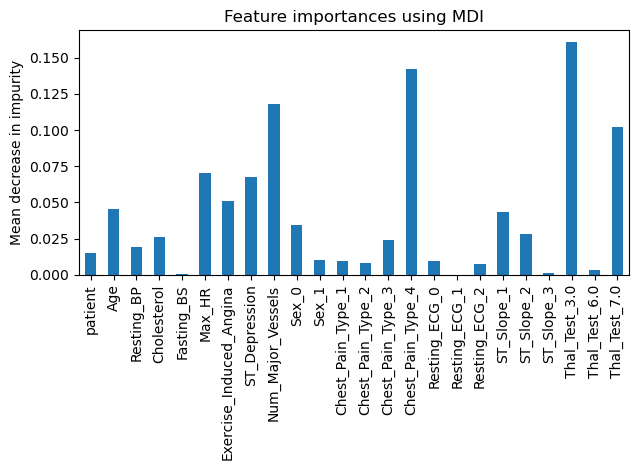

In [350]:
# get feature importance
importance = classifier_RF.feature_importances_
RF_importance = pd.Series(importance, index=X.columns)

fig, ax = plt.subplots()
RF_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


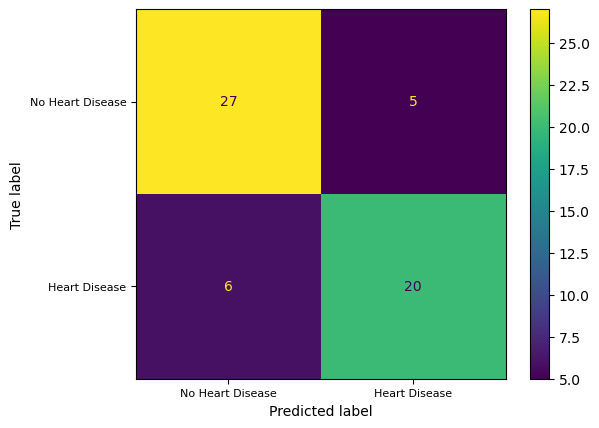

In [322]:
cm = confusion_matrix(y_test, y_predict_test_RF, labels = classifier_LR.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No Heart Disease', 'Heart Disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

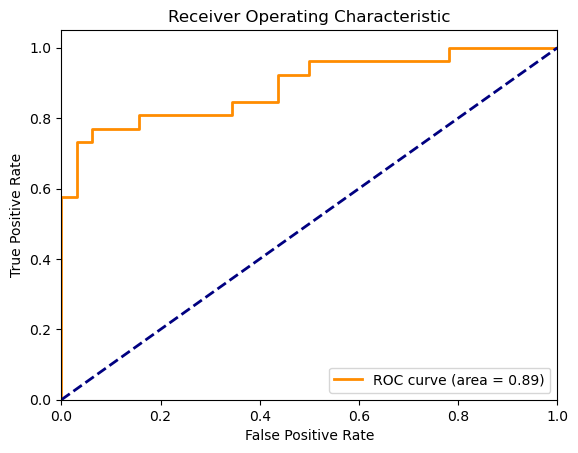

In [323]:
probas = classifier_RF.predict_proba(X_test)[:, 1]  # get the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model : Gradient Boosting

   - *Application*: Trying GBM here as they are a type of boosting that builds on weak learners to create a strong predictive model.
       - *Advantages*: They often provide predictive accuracy that cannot be beaten. They are flexible and can optimize on different loss functions and provides several hyperparameter tuning options that can make a substantial difference in model performance.
       - *Limitations*: GBMs are computationally expensive and can overfit if not tuned properly. They are also not as interpretable as simpler models like decision trees or logistic regression.


In [134]:
classifier_GB = GradientBoostingClassifier(n_estimators = 50, max_depth = 1, subsample=0.90, max_features=0.25, random_state = 123,'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5)

In [135]:
classifier_GB.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(max_depth=1, max_features=0.25, n_estimators=50,
                           random_state=123, subsample=0.9)

In [136]:
y_predict_test_GB = classifier_GB.predict(X_test)
y_predict_training_GB = classifier_GB.predict(X_train)

In [169]:
print("[Training] Accuracy score GB: (y_train, y_predict_training)", 
      f'{accuracy_score(y_train, y_predict_training_GB):.2f}')
print("[Training] Recall score GB: (y_train, y_predict_training)", 
      f'{recall_score(y_train, y_predict_training_GB):.2f}')

[Training] Accuracy score GB: (y_train, y_predict_training) 0.87
[Training] Recall score GB: (y_train, y_predict_training) 0.82


In [170]:
print("[Test] Accuracy score GB: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_test_GB, y_test):.2f}')
print("[Test] Recall score GB: (y_predict_test, y_test):",
      f'{recall_score(y_predict_test_GB, y_test):.2f}')

[Test] Accuracy score GB: (y_predict_test, y_test): 0.86
[Test] Recall score GB: (y_predict_test, y_test): 0.88


Text(0.5, 0, 'GB feature importances')

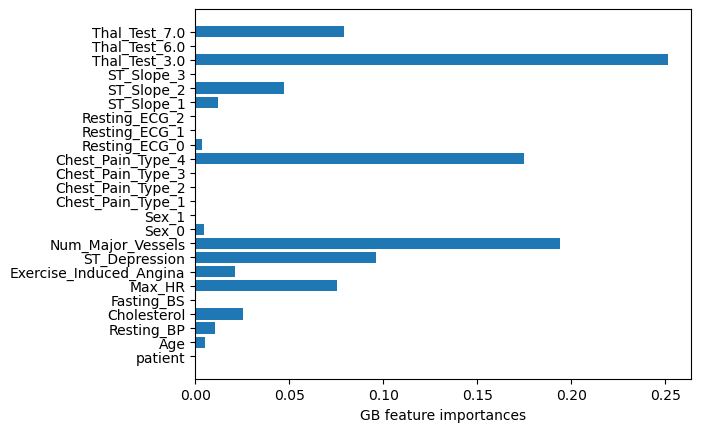

In [354]:

plt.barh(X.columns, classifier_GB.feature_importances_)
plt.xlabel("GB feature importances")

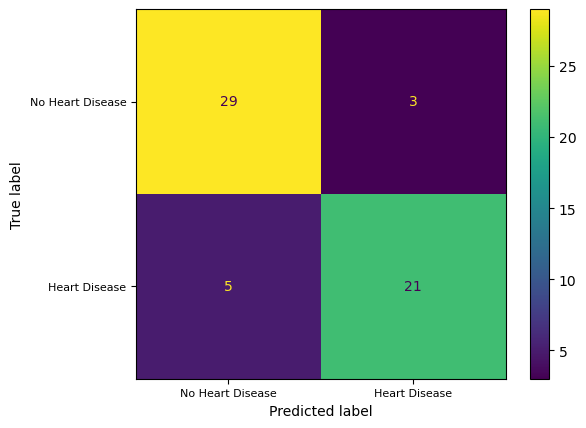

In [139]:
cm = confusion_matrix(y_test, y_predict_test_GB, labels = classifier_LR.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No Heart Disease', 'Heart Disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

In [144]:
param_grid = {
    'n_estimators':[10, 100, 500],
    'learning_rate':[0.001, 0.01, 0.1],
    'subsample':[0.1, 0.3 ,0.5],
    'max_depth':[1, 3, 5]
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
gscv = GridSearchCV(classifier_GB, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0).fit(X_train,y_train)

print("Optimal Parameters:", gscv.best_params_)
print("Best Score  :", gscv.best_score_)

# get predicted values
y_predict_GSCV_GB = gscv.predict(X_test)

print("[Test] Accuracy score Grid Search CV - GB: (y_predict_test, y_test):",
      f'{accuracy_score(y_predict_GSCV_GB, y_test):.2f}')

Optimal Parameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'subsample': 0.1}
Best Score  : 0.8407608695652175
[Test] Accuracy score Grid Search CV - GB: (y_predict_test, y_test): 0.83


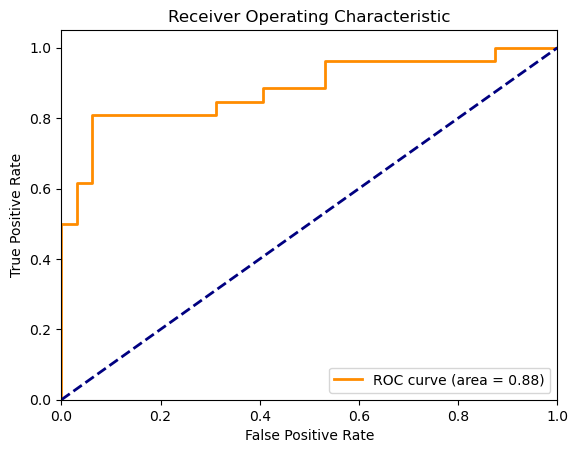

In [145]:
probas = classifier_GB.predict_proba(X_test)[:, 1]  # get the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Results
